<h1>OPENING A RESTAURANT TARGETING TOURISTS IN LONDON - Code - Coursera Capstone Project</h1>

In [1]:
#importing the needed libraries

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if needed
import folium

<h2>Getting the hotels data and performing needed analysis</h2>

In this part, we will call the Foursquare API and search for hotels around London city center. Then we will cluster the resulting venues using K-Means clustering to find areas were groups of hotels are located. Finally, we will find the centers of these areas and organize them in a data frame for later analysis.

In [55]:
#setting the needed information to call Foursquare API

CLIENT_ID = '****' # your Foursquare ID
CLIENT_SECRET = '****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
#setting the location to be searched, search word, and limits on results

london_lat = 51.5074
london_lon = -0.1278
search_query = 'Hotel'
radius = 500
limit_hotels = 50

In [4]:
#url to be used forr calling the API

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, london_lat, london_lon, VERSION, search_query, radius, limit_hotels)
url

'https://api.foursquare.com/v2/venues/search?client_id=N1DP4XUUYDNLDR5HOEYF3YS3C1RH30KVPX2HUSQVQMAIC05A&client_secret=0DEAMLOJ2WZIMLYT0R334JKWVTQOJ1ALZMR23ZUMUHOJDCGI&ll=51.5074,-0.1278&v=20180605&query=Hotel&radius=500&limit=50'

In [5]:
#making the call and holding saving the resulting json file

results = requests.get(url).json()

In [6]:
# assign relevant part of JSON to venues
hotels = results['response']['venues']

# tranform venues into a dataframe
hotels_df = json_normalize(hotels)
hotels_df.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4d274945d86aa09024d41dc0,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,Corinthia Hotel,v-1586617993,NaN
1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4bc54daa6a3e9c7496c8f548,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,Club Quarters Hotel,v-1586617993,NaN
2,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,5aa19ea5c666663fb5d39a6c,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,Hotel Indigo,v-1586617993,NaN
3,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4ba51d68f964a52030df38e3,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,St. Martin's Lane Hotel,v-1586617993,NaN
4,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4bc78b3c93bdeee1947f37ae,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,Amba Charing Cross Hotel,v-1586617993,NaN


In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in hotels_df.columns if col.startswith('location.')] + ['id']
hotels_df_filtered = hotels_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
hotels_df_filtered['categories'] = hotels_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hotels_df_filtered.columns = [column.split('.')[-1] for column in hotels_df_filtered.columns]

hotels_df_filtered

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Corinthia Hotel,Hotel,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,4d274945d86aa09024d41dc0
1,Club Quarters Hotel,Hotel,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,4bc54daa6a3e9c7496c8f548
2,Hotel Indigo,Hotel,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,5aa19ea5c666663fb5d39a6c
3,St. Martin's Lane Hotel,Hotel,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,4ba51d68f964a52030df38e3
4,Amba Charing Cross Hotel,Hotel,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,4bc78b3c93bdeee1947f37ae
5,Radisson Blu Edwardian Hampshire Hotel,Hotel,31-36 Leicester Square,GB,London,United Kingdom,NaN,306,"[31-36 Leicester Square, London, Greater Londo...","[{'label': 'display', 'lat': 51.5098669, 'lng'...",51.509867,-0.129767,NaN,WC2H 7LH,Greater London,4ac518b5f964a5209fa020e3
6,Great Scotland Yard Hotel,Hotel,3-5 Great Scotland Yard,GB,London,United Kingdom,NaN,157,"[3-5 Great Scotland Yard, London, SW1A 2HN, Un...","[{'label': 'display', 'lat': 51.5064253, 'lng'...",51.506425,-0.126146,NaN,SW1A 2HN,NaN,5d53299e9293ba0007f03f86
7,Afternoon Tea at the Corinthia Hotel,Tea Room,10 Whitehall Pl,GB,London,United Kingdom,NaN,256,"[10 Whitehall Pl, London, Greater London, SW1A...","[{'label': 'display', 'lat': 51.50657230583427...",51.506572,-0.124350,NaN,SW1A 2BD,Greater London,52764ec8498e83fe786a0595
8,FIT (W Hotel Gym),Gym / Fitness Center,NaN,GB,London,United Kingdom,NaN,384,"[London, Greater London, United Kingdom]","[{'label': 'display', 'lat': 51.51002945140006...",51.510029,-0.131398,NaN,NaN,Greater London,56fe22b0498ef2d2226413fb
9,W London Hotel,Hotel,"Leicester Square, 10 Wardour Street",GB,City of London,United Kingdom,NaN,458,"[Leicester Square, 10 Wardour Street, City of ...","[{'label': 'display', 'lat': 51.51084300795154...",51.510843,-0.131429,NaN,W1D 6QF,Greater London,4ad7ed82f964a520241021e3


In [8]:
#keeping only venues with the category "Hotel"

hotels_df_filtered = hotels_df_filtered[hotels_df_filtered.categories == 'Hotel']
hotels_df_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Corinthia Hotel,Hotel,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,4d274945d86aa09024d41dc0
1,Club Quarters Hotel,Hotel,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,4bc54daa6a3e9c7496c8f548
2,Hotel Indigo,Hotel,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,5aa19ea5c666663fb5d39a6c
3,St. Martin's Lane Hotel,Hotel,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,4ba51d68f964a52030df38e3
4,Amba Charing Cross Hotel,Hotel,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,4bc78b3c93bdeee1947f37ae
5,Radisson Blu Edwardian Hampshire Hotel,Hotel,31-36 Leicester Square,GB,London,United Kingdom,NaN,306,"[31-36 Leicester Square, London, Greater Londo...","[{'label': 'display', 'lat': 51.5098669, 'lng'...",51.509867,-0.129767,NaN,WC2H 7LH,Greater London,4ac518b5f964a5209fa020e3
6,Great Scotland Yard Hotel,Hotel,3-5 Great Scotland Yard,GB,London,United Kingdom,NaN,157,"[3-5 Great Scotland Yard, London, SW1A 2HN, Un...","[{'label': 'display', 'lat': 51.5064253, 'lng'...",51.506425,-0.126146,NaN,SW1A 2HN,NaN,5d53299e9293ba0007f03f86
9,W London Hotel,Hotel,"Leicester Square, 10 Wardour Street",GB,City of London,United Kingdom,NaN,458,"[Leicester Square, 10 Wardour Street, City of ...","[{'label': 'display', 'lat': 51.51084300795154...",51.510843,-0.131429,NaN,W1D 6QF,Greater London,4ad7ed82f964a520241021e3
10,The Piccadilly London West End Hotel,Hotel,65 Shaftsbury Ave,GB,London,United Kingdom,NaN,596,"[65 Shaftsbury Ave, London, Greater London, W1...","[{'label': 'display', 'lat': 51.51215571165802...",51.512156,-0.131767,NaN,W1D 6EX,Greater London,564c9b99498ec148d934dede
14,Haymarket Hotel,Hotel,1 Suffolk Pl,GB,London,United Kingdom,NaN,261,"[1 Suffolk Pl, London, Greater London, SW1Y 4H...","[{'label': 'display', 'lat': 51.50826687319245...",51.508267,-0.131315,NaN,SW1Y 4HX,Greater London,4abcec53f964a520b98720e3


In [9]:
#resetting index

hotels_df_filtered.reset_index(drop=True, inplace=True)
hotels_df_filtered.head(10)

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Corinthia Hotel,Hotel,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,4d274945d86aa09024d41dc0
1,Club Quarters Hotel,Hotel,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,4bc54daa6a3e9c7496c8f548
2,Hotel Indigo,Hotel,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,5aa19ea5c666663fb5d39a6c
3,St. Martin's Lane Hotel,Hotel,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,4ba51d68f964a52030df38e3
4,Amba Charing Cross Hotel,Hotel,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,4bc78b3c93bdeee1947f37ae
5,Radisson Blu Edwardian Hampshire Hotel,Hotel,31-36 Leicester Square,GB,London,United Kingdom,NaN,306,"[31-36 Leicester Square, London, Greater Londo...","[{'label': 'display', 'lat': 51.5098669, 'lng'...",51.509867,-0.129767,NaN,WC2H 7LH,Greater London,4ac518b5f964a5209fa020e3
6,Great Scotland Yard Hotel,Hotel,3-5 Great Scotland Yard,GB,London,United Kingdom,NaN,157,"[3-5 Great Scotland Yard, London, SW1A 2HN, Un...","[{'label': 'display', 'lat': 51.5064253, 'lng'...",51.506425,-0.126146,NaN,SW1A 2HN,NaN,5d53299e9293ba0007f03f86
7,W London Hotel,Hotel,"Leicester Square, 10 Wardour Street",GB,City of London,United Kingdom,NaN,458,"[Leicester Square, 10 Wardour Street, City of ...","[{'label': 'display', 'lat': 51.51084300795154...",51.510843,-0.131429,NaN,W1D 6QF,Greater London,4ad7ed82f964a520241021e3
8,The Piccadilly London West End Hotel,Hotel,65 Shaftsbury Ave,GB,London,United Kingdom,NaN,596,"[65 Shaftsbury Ave, London, Greater London, W1...","[{'label': 'display', 'lat': 51.51215571165802...",51.512156,-0.131767,NaN,W1D 6EX,Greater London,564c9b99498ec148d934dede
9,Haymarket Hotel,Hotel,1 Suffolk Pl,GB,London,United Kingdom,NaN,261,"[1 Suffolk Pl, London, Greater London, SW1Y 4H...","[{'label': 'display', 'lat': 51.50826687319245...",51.508267,-0.131315,NaN,SW1Y 4HX,Greater London,4abcec53f964a520b98720e3


In [10]:
#creating a map to view the resulting hotels and their locations
hotels_map = folium.Map(location=[london_lat, london_lon], zoom_start=15) # generate map centred around London

# add the hotels as blue circle markers
for lat, lng, label in zip(hotels_df_filtered.lat, hotels_df_filtered.lng, hotels_df_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

In [11]:
#How many hotels are there near london city center?
hotels_df_filtered.shape

(25, 16)

In [13]:
#prepare hotels dataframe for clustering

#adding an ID number to each venue will help in re-assembling the data after clustering
id_n = list(range(1,len(hotels_df_filtered)+1))
hotels_df_filtered['id_n'] = id_n
hotels_df_filtered.head()

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,id_n
0,Corinthia Hotel,Hotel,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,4d274945d86aa09024d41dc0,1
1,Club Quarters Hotel,Hotel,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,4bc54daa6a3e9c7496c8f548,2
2,Hotel Indigo,Hotel,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,5aa19ea5c666663fb5d39a6c,3
3,St. Martin's Lane Hotel,Hotel,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,4ba51d68f964a52030df38e3,4
4,Amba Charing Cross Hotel,Hotel,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,4bc78b3c93bdeee1947f37ae,5


In [14]:
# The dataset that will be used in K-Means clustering
X=hotels_df_filtered.loc[:,['id_n','lat','lng']]
X.head(10)

,id_n,lat,lng
0,1,51.506607,-0.124460
1,2,51.506985,-0.126020
2,3,51.510720,-0.130932
3,4,51.510526,-0.126705
4,5,51.508216,-0.124564
5,6,51.509867,-0.129767
6,7,51.506425,-0.126146
7,8,51.510843,-0.131429
8,9,51.512156,-0.131767
9,10,51.508267,-0.131315


In [15]:
#clustering the hotels based on their locations 
kmeans = KMeans(n_clusters = 3, init ='k-means++') # hotels will be clustered in 3 groups
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
centers = kmeans.cluster_centers_
print(centers) #to show coordinates of the center for each cluster 
X.head(10)

[[51.50979179 -0.13076647]
 [51.51046355 -0.12577598]
 [51.50692043 -0.12523318]]


,id_n,lat,lng,cluster_label
0,1,51.506607,-0.124460,2
1,2,51.506985,-0.126020,2
2,3,51.510720,-0.130932,0
3,4,51.510526,-0.126705,1
4,5,51.508216,-0.124564,2
5,6,51.509867,-0.129767,0
6,7,51.506425,-0.126146,2
7,8,51.510843,-0.131429,0
8,9,51.512156,-0.131767,0
9,10,51.508267,-0.131315,0


In [16]:
#adding the cluster label to each venue in the hotels data frame
X = X[['id_n','cluster_label']]
clustered_hotels = hotels_df_filtered.merge(X, left_on='id_n', right_on='id_n')
clustered_hotels.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id,id_n,cluster_label
0,Corinthia Hotel,Hotel,Whitehall Pl,GB,London,United Kingdom,NaN,247,"[Whitehall Pl, London, Greater London, SW1A 2B...","[{'label': 'display', 'lat': 51.50660672347560...",51.506607,-0.124460,NaN,SW1A 2BD,Greater London,4d274945d86aa09024d41dc0,1,2
1,Club Quarters Hotel,Hotel,8 Northumberland Avenue,GB,London,United Kingdom,NaN,131,"[8 Northumberland Avenue, London, Greater Lond...","[{'label': 'display', 'lat': 51.50698547522388...",51.506985,-0.126020,NaN,WC2N 5BY,Greater London,4bc54daa6a3e9c7496c8f548,2,2
2,Hotel Indigo,Hotel,1 Leicester Square,GB,London,United Kingdom,NaN,428,"[1 Leicester Square, London, Greater London, W...","[{'label': 'display', 'lat': 51.5107204, 'lng'...",51.510720,-0.130932,NaN,WC2H 7NA,Greater London,5aa19ea5c666663fb5d39a6c,3,0
3,St. Martin's Lane Hotel,Hotel,45 St. Martin'S Lane,GB,London,United Kingdom,NaN,356,"[45 St. Martin'S Lane, London, Greater London,...","[{'label': 'display', 'lat': 51.51052632268574...",51.510526,-0.126705,NaN,WC2N 4HX,Greater London,4ba51d68f964a52030df38e3,4,1
4,Amba Charing Cross Hotel,Hotel,"The Strand, Ste 2",GB,London,United Kingdom,NaN,241,"[The Strand, Ste 2, London, Greater London, WC...","[{'label': 'display', 'lat': 51.50821644805786...",51.508216,-0.124564,NaN,WC2N 5HX,Greater London,4bc78b3c93bdeee1947f37ae,5,2


In [17]:
#map showing each hotel with different color based on the cluster
map_clusters = folium.Map(location=[london_lat, london_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(clustered_hotels['lat'], clustered_hotels['lng'], clustered_hotels['name'], clustered_hotels['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters #show map

In [18]:
#putting the center of each cluster in a dataframe for later analysis
centers_df = pd.DataFrame(centers, columns =['c_lat', 'c_lon'])
cluster_label = list(range(0,3))
centers_df['cluster_label'] = cluster_label
centers_df

,c_lat,c_lon,cluster_label
0,51.509792,-0.130766,0
1,51.510464,-0.125776,1
2,51.506920,-0.125233,2


In [19]:
#map of centers
map_centers = folium.Map(location=[london_lat, london_lon], zoom_start=15)

# add markers to the map in different colors according to cluster
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(centers_df['c_lat'], centers_df['c_lon'], centers_df['cluster_label'], centers_df['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_centers)
       
map_centers #display the map showing 3 markers, one for each cluster 

<h2>Getting the restaurants data form Foursquare and analysing it</h2>

In this section, we will call foursquare API again and call for trending venues around london city center using the "explore" call, then we will clean the data, keep restaurants only, and classify these restaurants to one of the clusters created earlier using KNN classification. 

To do this we will use the centers data created before as a training set for KNN, then we will predict the cluster to which each restaurant belongs to by finding the nearest center.

In [20]:
#creating the url to call on foursquare API

limit_restaurants = 500

url2 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    london_lat, 
    london_lon, 
    radius, 
    limit_restaurants)
url2

'https://api.foursquare.com/v2/venues/explore?&client_id=N1DP4XUUYDNLDR5HOEYF3YS3C1RH30KVPX2HUSQVQMAIC05A&client_secret=0DEAMLOJ2WZIMLYT0R334JKWVTQOJ1ALZMR23ZUMUHOJDCGI&v=20180605&ll=51.5074,-0.1278&radius=500&limit=500'

In [21]:
#sving the results
results2 = requests.get(url2).json()

In [22]:
#getting the needed data and put it in a pandas dataframe
restaurants = results2['response']['groups'][0]['items']
    
restaurants_df = json_normalize(restaurants) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
restaurants_df = restaurants_df.loc[:, filtered_columns]

# filter the category for each row
restaurants_df['venue.categories'] = restaurants_df.apply(get_category_type, axis=1)

# clean columns
restaurants_df.columns = [col.split(".")[-1] for col in restaurants_df.columns]

restaurants_df

,name,categories,lat,lng
0,National Gallery,Art Museum,51.508876,-0.128478
1,Trafalgar Square,Plaza,51.507987,-0.128048
2,East Trafalgar Square Fountain,Fountain,51.508088,-0.127700
3,Sainsbury Wing National Gallery,Art Museum,51.508384,-0.129001
4,Trafalgar Square Lions,Outdoor Sculpture,51.507641,-0.127888
5,Nelson's Column,Monument / Landmark,51.507744,-0.127931
6,St Martin-in-the-Fields,Church,51.508746,-0.126507
7,National Portrait Gallery,Art Gallery,51.509438,-0.128032
8,Corinthia Hotel,Hotel,51.506607,-0.124460
9,Waterstones,Bookstore,51.507650,-0.127130


In [23]:
#number of venues recieved
restaurants_df.shape

(100, 4)

In [24]:
#keeping only the venues with categories containing "Restaurant"
restaurants_df_cleaned = restaurants_df[restaurants_df['categories'].str.contains('Restaurant')].reset_index(drop=True)
print(restaurants_df_cleaned.shape) #number of restaurants
restaurants_df_cleaned.head()

(24, 4)


,name,categories,lat,lng
0,Barrafina,Spanish Restaurant,51.509427,-0.125894
1,Thai Square,Thai Restaurant,51.507656,-0.129830
2,Tandoor Chop House,North Indian Restaurant,51.509192,-0.125638
3,Japan Centre,Japanese Restaurant,51.509761,-0.131273
4,Brumus,French Restaurant,51.508198,-0.131485


In [25]:
#creating a map of restaurants
restaurants_map = folium.Map(location=[london_lat, london_lon], zoom_start=15) # generate map centred around London

# add the hotels as yellow circle markers
for lat, lng, label in zip(restaurants_df_cleaned.lat, restaurants_df_cleaned.lng, restaurants_df_cleaned.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='yellow',
        popup=label,
        fill = True,
        fill_color='yellow',
        fill_opacity=0.6
    ).add_to(restaurants_map)

# display map
restaurants_map

In [26]:
#preparing the data that will be used in KNN classification
Xhat=restaurants_df_cleaned.loc[:,['lat','lng']] #classification based on the location coordinates
print(Xhat.shape) #number of restaurants
Xhat.head(10) #show dataframe

(24, 2)


,lat,lng
0,51.509427,-0.125894
1,51.507656,-0.129830
2,51.509192,-0.125638
3,51.509761,-0.131273
4,51.508198,-0.131485
5,51.508117,-0.133341
6,51.510221,-0.124524
7,51.509359,-0.132215
8,51.508744,-0.133083
9,51.509987,-0.124891


In [27]:
#the centers dataframe to be used for training KNN
centers_df 

,c_lat,c_lon,cluster_label
0,51.509792,-0.130766,0
1,51.510464,-0.125776,1
2,51.506920,-0.125233,2


In [28]:
#selecting classification features and target variable
X_train = centers_df[['c_lat', 'c_lon']].values
Y_train = centers_df['cluster_label']

In [29]:
#importing KNN library
from sklearn.neighbors import KNeighborsClassifier

In [30]:
k = 1 #classification based on the nearest center
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,Y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [31]:
#classify the restaurants based on the model created
yhat = neigh.predict(Xhat)
yhat[0:5]

array([1, 0, 1, 0, 0], dtype=int64)

In [32]:
#putting the results in a dataframe
KNN_results = pd.DataFrame(yhat, columns=['class'])
KNN_results

,class
0,1
1,0
2,1
3,0
4,0
5,0
6,1
7,0
8,0
9,1


In [33]:
#joining the results with the restaurants dataframe
restaurants_classified = pd.concat([restaurants_df_cleaned, KNN_results], axis=1, sort=False)

In [34]:
#view resulting dataframe
restaurants_classified

,name,categories,lat,lng,class
0,Barrafina,Spanish Restaurant,51.509427,-0.125894,1
1,Thai Square,Thai Restaurant,51.507656,-0.129830,0
2,Tandoor Chop House,North Indian Restaurant,51.509192,-0.125638,1
3,Japan Centre,Japanese Restaurant,51.509761,-0.131273,0
4,Brumus,French Restaurant,51.508198,-0.131485,0
5,Milos,Greek Restaurant,51.508117,-0.133341,0
6,Wahaca,Mexican Restaurant,51.510221,-0.124524,1
7,Kanada-Ya,Ramen Restaurant,51.509359,-0.132215,0
8,Scully,Restaurant,51.508744,-0.133083,0
9,Lao Café,Asian Restaurant,51.509987,-0.124891,1


In [35]:
#show restaurante in each area in different color
map_rest_class = folium.Map(location=[london_lat, london_lon], zoom_start=15)

# add markers to the map
marker_colors = ['red','green','blue']
for lat, lon, poi, cluster in zip(restaurants_classified['lat'], restaurants_classified['lng'], restaurants_classified['name'], restaurants_classified['class']):
    label = folium.Popup(str(poi) + ' Class ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=marker_colors[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(map_rest_class)
       
map_rest_class

<h2>Finding the suitable spot</h2>

In this section we will see what category of restaurants is most trending and desired in center of london. Since our restaurants data represent venues with highest foot-traffic then we will look at the frequency of restaurant category repetition as this are the venues recieving customers. 

Then we will look at the number of restaurants in each of the three areas to choose the cluster of hotels with the minimum level of competion, as well as the number of hotels in that cluster to correctly evaluate the opportunity. 

In [40]:
#count number of restaurants in each area
restaurants_count = restaurants_classified['class'].value_counts().rename_axis('class').reset_index(name='counts')
restaurants_count

,class,counts
0,0,14
1,1,10


In [44]:
#counting number of trending restaurants of each unique category
trending_restaurants = restaurants_classified['categories'].value_counts().rename_axis('categories').reset_index(name='counts')
trending_restaurants

,categories,counts
0,Asian Restaurant,2
1,French Restaurant,2
2,Japanese Restaurant,2
3,Chinese Restaurant,2
4,Seafood Restaurant,1
5,North Indian Restaurant,1
6,Italian Restaurant,1
7,Greek Restaurant,1
8,Spanish Restaurant,1
9,Ramen Restaurant,1


In [45]:
#keeping the five most frequent categories
trending_restaurants = trending_restaurants.head()

In [46]:
#show top five categories
trending_restaurants

,categories,counts
0,Asian Restaurant,2
1,French Restaurant,2
2,Japanese Restaurant,2
3,Chinese Restaurant,2
4,Seafood Restaurant,1


In [50]:
#make "categories" as index for visiualization
trending_restaurants = trending_restaurants.set_index('categories')
trending_restaurants

,counts
categories,
Asian Restaurant,2
French Restaurant,2
Japanese Restaurant,2
Chinese Restaurant,2
Seafood Restaurant,1


In [51]:
#importing bar charts library
import matplotlib as mpl
import matplotlib.pyplot as plt

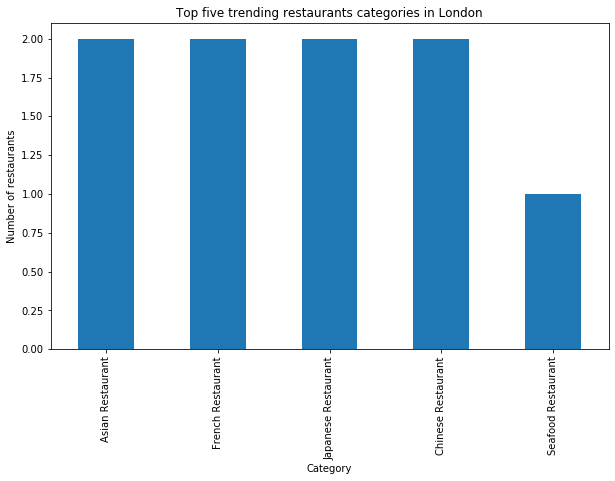

In [53]:
#plotting the top five restaurant categories
trending_restaurants.plot(kind='bar', figsize=(10, 6), legend=None)

plt.xlabel('Category') # add to x-label to the plot
plt.ylabel('Number of restaurants') # add y-label to the plot
plt.title('Top five trending restaurants categories in London') # add title to the plot

plt.show()

In [54]:
#counting hotels in each area to evaluate potential
hotels_count = clustered_hotels['cluster_label'].value_counts().rename_axis('cluster').reset_index(name='counts')
hotels_count

,cluster,counts
0,0,11
1,2,8
2,1,6
